In [1]:
import os
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
print(os.listdir("../input/chest-xray-pneumonia/chest_xray/train"))

Using TensorFlow backend.


['PNEUMONIA', 'NORMAL']


In [2]:
train_path="../input/chest-xray-pneumonia/chest_xray/train"
test_path="../input/chest-xray-pneumonia/chest_xray/test"
val_path="../input/chest-xray-pneumonia/chest_xray/train"

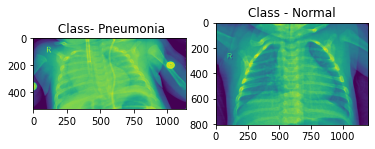

In [3]:
# using * wild card character for getting all the files of training -> pneumonia
plt.subplot(1,2,1)
img=glob(train_path+"/PNEUMONIA/*.jpeg") 
img=np.asarray(plt.imread(img[0]))
plt.title(' Class- Pneumonia')
plt.imshow(img)

plt.subplot(1,2,2)
pmg=glob(train_path+"/NORMAL/*.jpeg")

pmg=np.asarray(plt.imread(pmg[0]))
plt.title('Class - Normal')
plt.imshow(pmg)


# **ImageDataGenerator**

1. ImageDataGenerator reduces the laborious task of labelling each image by directly labelling the corressponding image folder and hence images.
2. We also use it here to increase our training data by shearing,flipping so that our model trains well.

In [4]:
train_gen=ImageDataGenerator(rescale=1./255,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True)

val_gen=ImageDataGenerator(rescale=1/.255)

train_batch=train_gen.flow_from_directory(train_path,target_size=(224,224),batch_size=32,classes=["NORMAL","PNEUMONIA"],class_mode="categorical")

validation_batch=val_gen.flow_from_directory(val_path,target_size=(224,224),batch_size=32,classes=["NORMAL","PNEUMONIA"],class_mode="categorical")

testing_batch=val_gen.flow_from_directory(test_path,target_size=(224,224),batch_size=32,classes=["NORMAL","PNEUMONIA"],class_mode="categorical")

Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


****Below code highlights the following things****
1. 3 denotes that the input image is colored(RGB).
2. (224,224) denotes the array dimensions in which pixel value is stored of each image.

In [5]:
train_batch.image_shape

(224, 224, 3)

# **Transfer Learning**

Using [VGG16](https://neurohive.io/en/popular-networks/vgg16/) we remove the last layer as its of 1000 size(used for classifying 1000 classes), we only have 2 classes here

In [6]:
vgg=VGG16(input_shape=train_batch.image_shape,weights='imagenet',include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [7]:
for layer in vgg.layers:
    layer.trainable=False

In [8]:
x=Flatten()(vgg.output)

In [9]:
prediction=Dense(2,activation='softmax')(x)

model=Model(inputs=vgg.input,outputs=prediction)

In [10]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [11]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


163

In [13]:
model.fit_generator(train_batch,validation_data=testing_batch,epochs=5,steps_per_epoch=len(train_batch))

Epoch 1/5
163/163 [==============================] - 195s 1s/step - loss: 0.0793 - accuracy: 0.9697 - val_loss: 115.2907 - val_accuracy: 0.6795
Epoch 2/5
163/163 [==============================] - 190s 1s/step - loss: 0.0812 - accuracy: 0.9691 - val_loss: 369.3570 - val_accuracy: 0.6747
Epoch 3/5
163/163 [==============================] - 191s 1s/step - loss: 0.0662 - accuracy: 0.9747 - val_loss: 215.1908 - val_accuracy: 0.6811
Epoch 4/5
163/163 [==============================] - 193s 1s/step - loss: 0.0760 - accuracy: 0.9741 - val_loss: 391.6729 - val_accuracy: 0.6747
Epoch 5/5
163/163 [==============================] - 192s 1s/step - loss: 0.0587 - accuracy: 0.9791 - val_loss: 366.4241 - val_accuracy: 0.6619


In [14]:
model.save('model.h5')